#📄🔥 SkimLit: An NLP Project to Classify Research Paper Abstract Sentences

In this project, I am going to replicate the deep learning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/pdf/1710.06071.pdf) & [Neural networks for joint sentence classification in medical paper abstracts.](https://arxiv.org/pdf/1612.05251.pdf)

In the process of replicating the model in the paper, I am also going to experiment by creating multiple other models.

The paper PubMed 200k RCT presented a new dataset consisting of ~2,00,000 labelled Randomized Controlled Trial (RCT) abstracts and the goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

### Problem Statement
The number of RCT papers released is continuring to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

### Solution
Create an NLP model to classify abstract sentences into the role they play (e.g. Background, Objective, Methods, Result and Conclusion etc.) to enable reseachers to skim through the literature and dive deeper when necessary.

1. Data: [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/pdf/1710.06071.pdf)
2. Model: [Neural networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf)

## Approach of execution

- Download a text dataset from Github https://github.com/Franck-Dernoncourt/pubmed-rct
- Writing a preprocessing function to prepare our data for modelling
- Setting up a series of modelling experiments
  - Making a baseline (TF-IDF / Naive Baye's Classifier)
  - Deep Learning models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
- Building first multimodal model (taking multiple types of data inputs)
  - Replicating the model architecture from paper [Neural networks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1612.05251.pdf)
- Building another tribrid model using PubMed BERT Expert
- Making predictions on PubMed abstracts from the wild

### Let's confirm access to a GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-071845c0-8f86-f1fd-d967-08b797656581)


## Get Data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 21.40 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


There are four folders, each contain a different version of the PubMed 200k RCT dataset.

Looking at the README file from the GitHub page, we get the following information:
- PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
- PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. PubMed_20k_RCT_numbers_replaced_with_at_sign).

For experimentation, the dataset we are focusing on is
`PubMed_20k_RCT_nubmers_replaced_with_at_sign`

In [3]:
# Check what files are there in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


dev is short for development set, which is another name for validation set.

In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check path and all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Pre-process data

Our data is in the form of text files, let's write code to read each of the lines in a target file.

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

Let's try our `get_lines()` function on training data (train.txt)

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (\t) and each sentence finishes with a new line (\n).

Different abstracts are separated by abstract ID's (lines beginning with ###) and newlines (\n).

Let's write a function to perform the following steps:
- Take a target file of abstract samples.
- Read the lines in the target file.
- For each line in the target file:
  - If the line begins with ###, mark it as an abstract ID and the beginning of a new abstract.
    - Keep count of the number of lines in a sample.
  - If the line begins with \n, mark it as the end of an abstract sample.
    - Keep count of the total lines in a sample.
  - Record the text before the \t as the label of the line.
  - Record the text after the \t as the text of the line.
- Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  - "line_number" - the position of the line in the abstract
  - "target" - the role of the line in the abstract
  - "text" - the text of the line in the abstract
  - "total_lines" - the total lines in an abstract samples
- Abstract IDs and newlines should be omitted from the returned preprocessed data.

In [8]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from.
  """
  input_lines = get_lines(filename)                             # get all lines from filename
  abstract_lines = ""                                           # create an empty abstract
  abstract_samples = []                                         # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"):                                  # check to see if line is an ID line
      abstract_id = line
      abstract_lines = ""                                       # reset abstract string
    elif line.isspace():                                        # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()         # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}                                          # Create empty dict to store data from line
        target_text_split = abstract_line.split("\t")           # split target label from text
        line_data["target"] = target_text_split[0]              # get target label
        line_data["text"] = target_text_split[1].lower()        # get target text and lower it
        line_data["line_number"] = abstract_line_number         # what number line does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract
        abstract_samples.append(line_data)                      # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled,  the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Let's turn our list of dictionaries into a DataFrame, so that we can visualize it better.

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Now our data is in DataFrame form, we can perform some data analysis on it.

In [12]:
# Distributino of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Looks like sentences with the `OBJECTIVE` label are the least common.

Let's check distribution of abstract lengths?

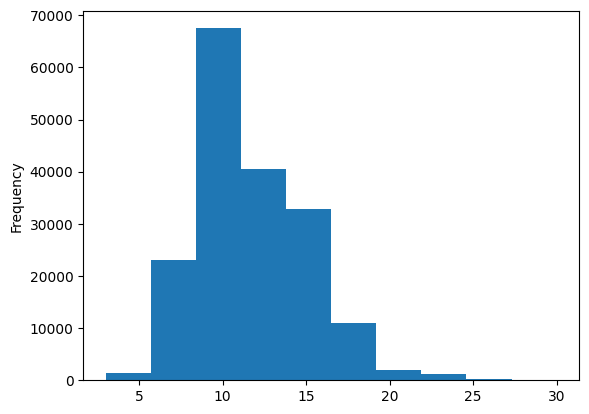

In [13]:
train_df.total_lines.plot.hist();

In training data, most of the abstracts are around 7 to 15 sentences in length.

### Get list of sentences

While building our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# Let's view first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels

We are going to create one hot and label encoded labels.

For baseline model, label encoded labels are fine, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded lables.

In [16]:
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [17]:
# Label encode labels

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in [Neural networks for joint sentence classification in medical paper abstracts.](https://arxiv.org/pdf/1612.05251.pdf)

For each model, we'll train it on the training data and evaluate it on the validation data.

### Model 0: Baseline model

Our first model will be a Tf-Idf Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map.](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

To build it, we'll create a Scikit-Learn `Pipeline` which uses the `TfidfVectorizer` class to convert our abstract sentences to numbers using the Tf-Idf algorithm and then learns to classify our sentences using the MultinomialNB algorithm.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [21]:
# Baseline predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

So, our Baseline accuracy is 72.18% and we will try to beat this using deep learning models.

Further to evaluate the model, let's write a helper function `calculate_results()` which will return
- accuracy
- precision
- recall
- f1-score

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns:
      a dictionary of accuracy, precision, recall and f1 score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)

  # Calculate model precision, recall and f1 score using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1_score": model_f1}
  return model_results

In [23]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

### Preparing data for Deep Learning Sequence models

We will create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence. When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
# How long is each sentece on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

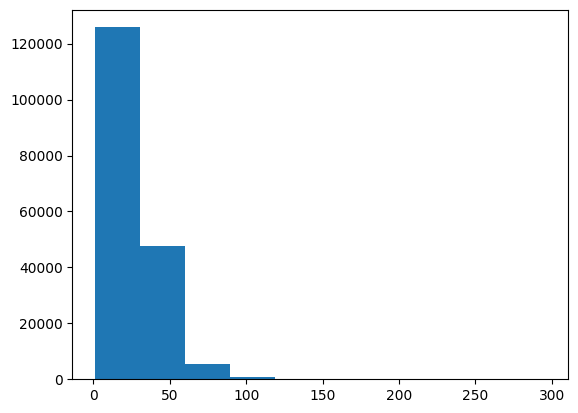

In [26]:
# Distribution of lengths
import matplotlib.pyplot as plt

plt.hist(sent_lens);

Majority of our sentences are between 0 and 50 tokens in length.

We can use NumPy's `percentile` to find the value which covers 95% of the sentence lengths.

In [27]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

We see that 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length.

In [28]:
# Maximum sentence length in the training set
max(sent_lens)

296

#### Create text vectorizer

We'll user the `TextVectorization` layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

PubMed 200k RCT paper states the vocabulary size of the 20k_dataset as 68,000. So we'll use that as our max_tokens parameter.

In [29]:
# Max vocab size
max_tokens = 68000

And we found that a sentence length of 55 covers 95% of the training sentences, we'll use that as our `output_sequence_length` parameter.

In [30]:
# Create text vectorizer

from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer

import random
target_sentence = random.choice(train_sentences)
print(f"text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

text:
hs = @ @ ; p = @ , unpaired t-test ) .

Length of text: 13

Vectorized text:
[[2399   14 9806 2584    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [33]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#### Create custom text embedding

Our `token_vectorization` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationship between those numbers.

To create a richer numerical representation of our text, we use an embedding.
As our model learns (by going through many different examples of abstract sentences and their labels), it'll update it's embeddings to better represent the relationship between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's `Embedding` layer.

In [35]:
# Create token embedding layer

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128,                    # dim of embedding output
                               mask_zero=True,                    # masking to handle variable sequence lengths
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
hs = @ @ ; p = @ , unpaired t-test ) .
Sentence after vectorization (before embedding):
[[2399   14 9806 2584    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
Sentence after embedding:
[[[ 0.03755749 -0.01183422  0.01391611 ...  0.03982503  0.02490867
    0.00612553]
  [ 0.00707192  0.03906992 -0.02717898 ...  0.03926061 -0.00251675
    0.0044727 ]
  [ 0.02270884  0.04234657  0.04209692 ... -0.04751341  0.0155174
   -0.01582653]
  ...
  [ 0.02411178 -0.04004117  0.01008137 ...  0.00632795 -0.00724809
    0.04927952]
  [ 0.02411178 -0.04004117  0.01008137 ...  0.00632795 -0.00724809
    0.04927952]
  [ 0.02411178 -0.04004117  0.01008137 ...  0.00632795 -0.00724809
    0.04927952]]]

Embedded sentence shape: (1, 55, 128)


#### Create dataset using `tf.data` api

The `tf.data` api provides methods which enable faster data loading.

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches. Doing so we'll ensure TF loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataseet` we can use the methods `batch()` and `prefetch()`, the parameter `tf.data.AUTOTUNE` will also allow TF to determine the optimal amount of compute to use to prepare datasets.

In [36]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# take the TensorSliceDataset and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings

Structure of tensorflow deep learning functional api models

> Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [38]:
# Create 1D convolutional model to process sequences

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

Since our training data contains nearly 1,80,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [40]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=4,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/4
562/562 [==============================] - 20s 30ms/step - loss: 0.9121 - accuracy: 0.6411 - val_loss: 0.6895 - val_accuracy: 0.7394
Epoch 2/4
562/562 [==============================] - 6s 11ms/step - loss: 0.6630 - accuracy: 0.7523 - val_loss: 0.6342 - val_accuracy: 0.7696
Epoch 3/4
562/562 [==============================] - 4s 8ms/step - loss: 0.6210 - accuracy: 0.7739 - val_loss: 0.5977 - val_accuracy: 0.7839
Epoch 4/4
562/562 [==============================] - 4s 7ms/step - loss: 0.5902 - accuracy: 0.7900 - val_loss: 0.5794 - val_accuracy: 0.7856


In [41]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5790 - accuracy: 0.7909


[0.5790314078330994, 0.7909108996391296]

In [42]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[5.70783317e-01, 1.50105268e-01, 9.30962116e-02, 1.26886919e-01,
        5.91283441e-02],
       [5.75995207e-01, 2.36136869e-01, 2.65917070e-02, 1.44679442e-01,
        1.65967513e-02],
       [2.95184821e-01, 7.51379458e-03, 1.65274879e-03, 6.95596397e-01,
        5.23574527e-05],
       ...,
       [1.43126190e-05, 5.42506983e-04, 1.19980867e-03, 3.88570652e-06,
        9.98239517e-01],
       [1.07397735e-01, 3.97272855e-01, 7.94741660e-02, 5.98072298e-02,
        3.56048018e-01],
       [1.48811072e-01, 7.61145413e-01, 3.42380404e-02, 1.06222620e-02,
        4.51831259e-02]], dtype=float32)

In [43]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [44]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.790910896332583,
 'precision': 0.7919601753098315,
 'recall': 0.790910896332583,
 'f1_score': 0.7858706648418324}

### Model 2: Feature extraction with pretrained token embeddings

In the research paper, they have used a pretrained GloVe embedding as a way to initialise their token embeddings.

To emulate this, first we will experiment with [the pretrained Universal Sentence Encoder embeddings from TensorFlow Hub.]( https://tfhub.dev/google/universal-sentence-encoder/4)

The model structure will look like:
> Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)

There is no tokenization layer in above structure because Universal Sentence Encoder (USE) takes care of tokenization.

In [ ]:
# Download pretrained TensorFlow Hub USE (now available on Kaggle)
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
trough tapentadol concentrations increased during repeat dosing until reaching steady-state by the third dose .

Sentence after embedding:
[ 0.06026393  0.01410135  0.01591234 -0.0138323  -0.04677391  0.0378407
  0.03265569 -0.05337685  0.0721679   0.08102266  0.07090764  0.07693461
  0.01902723 -0.04265333  0.01581454 -0.011852   -0.07275003 -0.03535884
  0.00856467  0.06192243 -0.08798119  0.01995389 -0.04444689  0.03900659
 -0.03216382  0.046551    0.05612224  0.00883714 -0.00835421  0.02549172] (truncated output)...

Length of sentence embedding:
512


In [ ]:
# Shape of embedding
use_embedded_sentence.shape

TensorShape([1, 512])

#### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


We can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set `training=False` when we instantiated our USE feature extractor layer. Also the model size is ~20 times.

So when we train our model, only the top two output layers will be trained.

In [ ]:
# Fit feature extractor model for 4 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=4,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/4
562/562 [==============================] - 10s 13ms/step - loss: 0.9158 - accuracy: 0.6497 - val_loss: 0.7968 - val_accuracy: 0.6892
Epoch 2/4
562/562 [==============================] - 7s 13ms/step - loss: 0.7700 - accuracy: 0.7025 - val_loss: 0.7541 - val_accuracy: 0.7045
Epoch 3/4
562/562 [==============================] - 8s 13ms/step - loss: 0.7537 - accuracy: 0.7117 - val_loss: 0.7400 - val_accuracy: 0.7118
Epoch 4/4
562/562 [==============================] - 7s 12ms/step - loss: 0.7204 - accuracy: 0.7250 - val_loss: 0.7116 - val_accuracy: 0.7274


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7168 - accuracy: 0.7289


[0.7167913913726807, 0.7289156913757324]

##### Create an helper function which converts prediction probabilities to classes and then returns model results using `calculate_results()`

In [47]:
def predict_and_result(model, valid_dataset=valid_dataset, val_labels=val_labels_encoded):
  """
  Calculates prediction probabilites, convert them to pred classes and calculate results

  Args:
      model: Deep model which is being evaluated
      valid_dataset: validation dataset
      val_labels: true labels of validation dataset

  Returns:
      Returns a dictionary of metric scores
  """
  # Make predictions with the model
  pred_probs = model.predict(valid_dataset)

  # Convert the predictions to classes
  model_preds = tf.argmax(pred_probs, axis=1)

  # Calcuate results on validation set
  results = calculate_results(y_true=val_labels,
                              y_pred=model_preds)

  return results

In [ ]:
# Check results of model_2 (feature_extractor_model)
model_2_results = predict_and_result(model_2)
model_2_results

945/945 [==============================] - 10s 10ms/step


{'accuracy': 0.7289156626506024,
 'precision': 0.7239974992776204,
 'recall': 0.7289156626506024,
 'f1_score': 0.7232632129489949}

### Model 3: Conv1D with character embeddings

#### Creating a character level tokenizer

The paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, let's create a one with character embedding.

The difference between a character and token embedding is that the character embedding is created using sequences split into characters whereas a token embedding is created on sequence split into tokens.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the `TextVectorization` class and then passing those vectorized sequences through an `Embedding` layer.

Before we vectorize our sequences on a character-level we need to split them into characters.

In [48]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
import random
random_training_sentence = random.choice(train_sentences)
split_chars(random_training_sentence)

'p o s t g r a d u a t e   t r a i n e e s   (   n   =   @   )   a n d   c l i n i c a l   f a c u l t y / s t a f f   (   n   =   @   )   w i l l   b e   r a n d o m i z e d   t o   e a c h   o f   t h e   t h r e e   f o l l o w i n g   i n t e r v e n t i o n s   i n   a   f a c t o r i a l   d e s i g n   (   a x b x c   )   .'

Let's create character-lvel datasets by splitting our sequence datasets into characters.

In [49]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


To figure out how long our vectorized character sequences should be, let's check the distribution of our character sequence lengths.

In [ ]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

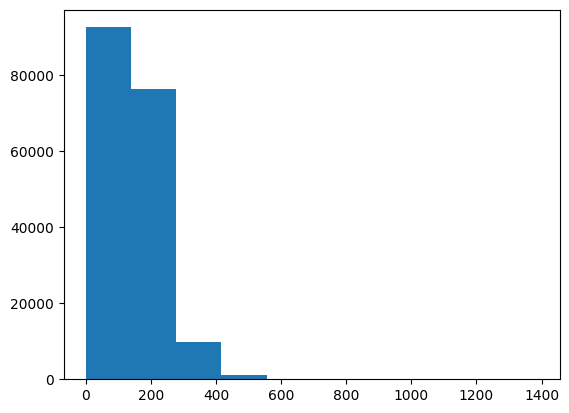

In [ ]:
# Check the distribution of our sequences at character-level
plt.hist(char_lens);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

We will use this 290 as `output_sequence_length` in our `TextVectorization` layer.
We'll set `max_token` to 28 => 26 letters of alphabet + space + oov

In [ ]:
# Create char-level token vectorizer instance
char_vectorizer = TextVectorization(max_tokens=28,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer
char_vectorizer.adapt(train_chars)

In [ ]:
# check character vocabulary details
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common character: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   i n t e r v e n t i o n a l   m a n a g e m e n t   o f   s t r o k e   (   i m s   )   -   i i i   t r i a l   r a n d o m i z e d   p a t i e n t s   w i t h   a c u t e   i s c h e m i c   s t r o k e   t o   i n t r a v e n o u s   t i s s u e - t y p e   p l a s m i n o g e n   a c t i v a t o r   (   t p a   )   p l u s   e n d o v a s c u l a r   t h e r a p y   v e r s u s   i n t r a v e n o u s   t p a   t h e r a p y   a l o n e   w i t h i n   @   h o u r s   f r o m   s y m p t o m   o n s e t   .

Length of chars: 223

Vectorized chars:
[[ 3 13  2  4  6  3  2  8 21  2  6  3  4  7  6  5 12 15  5  6  5 18  2 15
   2  6  3  7 17  9  3  8  7 23  2  4 15  9  4  4  4  3  8  4  5 12  8  5
   6 10  7 15  4 25  2 10 14  5  3  4  2  6  3  9 20  4  3 13  5 11 16  3
   2  4  9 11 13  2 15  4 11  9  3  8  7 23  2  3  7  4  6  3  8  5 21  2
   6  7 16  9  3  4  9  9 16  2  3 19 14  2 14 12  5  9 15  4  6  7 18  2
   6  5 11  3  4 21  5  3  7  8  3 14  5 14 12 16

#### Creating a character level embedding

The input dimension to our char embedding layer will be equal to the size of char_vocab i.e. 28. And since we're following the structure of the model in the research paper, the output dimension of the character embedding will be 25.

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=28,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

# Test our character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorizationn and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   i n t e r v e n t i o n a l   m a n a g e m e n t   o f   s t r o k e   (   i m s   )   -   i i i   t r i a l   r a n d o m i z e d   p a t i e n t s   w i t h   a c u t e   i s c h e m i c   s t r o k e   t o   i n t r a v e n o u s   t i s s u e - t y p e   p l a s m i n o g e n   a c t i v a t o r   (   t p a   )   p l u s   e n d o v a s c u l a r   t h e r a p y   v e r s u s   i n t r a v e n o u s   t p a   t h e r a p y   a l o n e   w i t h i n   @   h o u r s   f r o m   s y m p t o m   o n s e t   .

Embedded chars (after vectorizationn and embedding):
[[[ 3.7019636e-02 -6.0997903e-05  1.4872853e-02 ...  1.7164301e-02
   -1.4167346e-02 -3.3157874e-02]
  [ 4.8528243e-02  4.9719144e-02  4.5195986e-02 ... -1.5508998e-02
   -3.2621220e-02 -3.4902118e-02]
  [ 4.6235252e-02 -3.7131499e-02  2.0709697e-02 ...  4.1690972e-02
    3.4845363e-02 -2.5633110e-02]
  ...
  [-3.4524895e-02  2.1609914e-02  1.4014933e-02 ...  4.40957

#### Building a Conv1D model to fit on character embeddings

Structure of the model_3
> Input (character level text) -> tokenize -> embedding -> layers (conv1d, GlobalMaxPool1D) -> output (label probability)

In [ ]:
# Make conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of model_3
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

Before fitting our model on the data, we'll create char-level batched `PrefetchedDataset`

In [ ]:
# Create char dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=4,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/4
562/562 [==============================] - 5s 6ms/step - loss: 1.2733 - accuracy: 0.4800 - val_loss: 1.0730 - val_accuracy: 0.5711
Epoch 2/4
562/562 [==============================] - 3s 5ms/step - loss: 1.0254 - accuracy: 0.5892 - val_loss: 0.9519 - val_accuracy: 0.6287
Epoch 3/4
562/562 [==============================] - 3s 5ms/step - loss: 0.9398 - accuracy: 0.6316 - val_loss: 0.8770 - val_accuracy: 0.6592
Epoch 4/4
562/562 [==============================] - 4s 6ms/step - loss: 0.8804 - accuracy: 0.6557 - val_loss: 0.8501 - val_accuracy: 0.6725


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8626 - accuracy: 0.6641


[0.862583577632904, 0.6641069650650024]

In [ ]:
# Make predictions and check results
model_3_results = predict_and_result(model_3, valid_dataset=val_char_dataset)
model_3_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 0.6641069773599894,
 'precision': 0.6677196378109952,
 'recall': 0.6641069773599894,
 'f1_score': 0.6547400199051074}

These are the lowest scores amoung our previous results.

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

This hybrid token embedding layer is a combination of token embeddings and character embeddings, i.e. they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in the paper, we're going to go through the following steps:
1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using `layers.Concatenate`) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to fig 1 and sec 4.2 of Paper -> Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
# 4. Create output layers - addition of dropout discussed in paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(256, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
# Get summary of our first hybrid model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

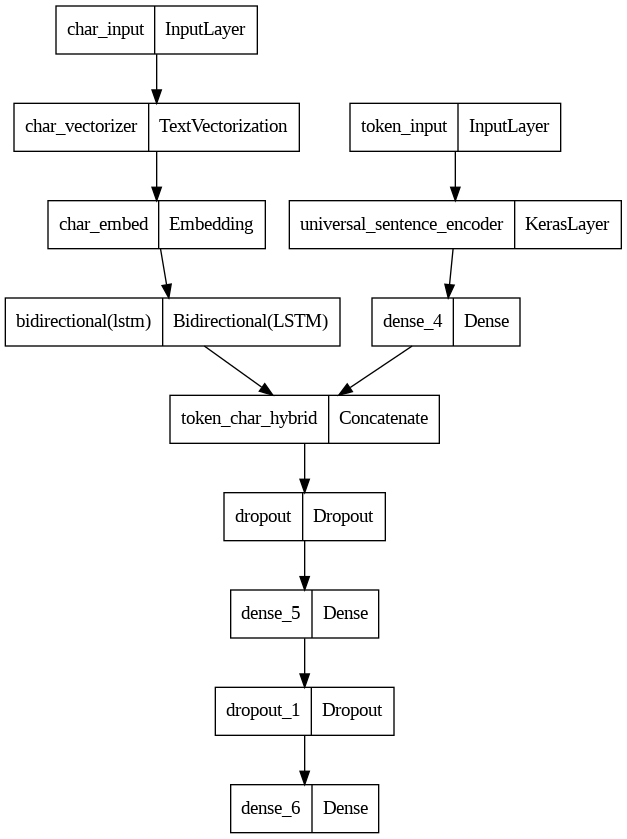

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Combining token and character data into a `tf.data` dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeating same steps fro validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting a model on token and character level sequences

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=4,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/4
562/562 [==============================] - 27s 36ms/step - loss: 0.9640 - accuracy: 0.6213 - val_loss: 0.7850 - val_accuracy: 0.6995
Epoch 2/4
562/562 [==============================] - 18s 31ms/step - loss: 0.7839 - accuracy: 0.6967 - val_loss: 0.7123 - val_accuracy: 0.7314
Epoch 3/4
562/562 [==============================] - 19s 33ms/step - loss: 0.7614 - accuracy: 0.7096 - val_loss: 0.6956 - val_accuracy: 0.7370
Epoch 4/4
562/562 [==============================] - 18s 31ms/step - loss: 0.7299 - accuracy: 0.7254 - val_loss: 0.6617 - val_accuracy: 0.7533


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.6687 - accuracy: 0.7447


[0.6686740517616272, 0.7446709871292114]

In [ ]:
# Make predictions and check results
model_4_results = predict_and_result(model_4, valid_dataset=val_char_token_dataset)
model_4_results

945/945 [==============================] - 17s 17ms/step


{'accuracy': 0.7446709916589435,
 'precision': 0.7426207496062147,
 'recall': 0.7446709916589435,
 'f1_score': 0.7399277149451993}

### Model 5: Transffer Learning with pretrained token_embeddings + character_embeddings + positional_embeddings

We can see that combining token embeddings and character embeddings gave our model a little performance boost.

Now let's apply feature engineering to our data.

If we look at the abstract sentences they typically follow order:
> background -> objective -> methods -> methods -> results -> results -> conclusion

We can't engineer the sequence labels themselves into the training data, but we can encode the order of a set of sequences in an abstract.

Earlier we have stored `line_number` and `total_lines` in a Dataframe. These columns are features which didn't necessarily come with the training data but we have created them and can be passed to our model as *positional embedding*. In other words, the positional embedding is where the sentence appears in an abstract.

If we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and track the position of each individual line and pass it to our model, to help improve the performance.


#### Create positional embeddings

Since our `line_number` and `total_line` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with line_number=5 is five times greater than a line with line_number=1, we will use one-hot-encoding to encode our `line_number` and `total_lines` features using `tf.one_hot` utility.

`tf.one_hot` accepts an array (or tensor) as input and the `depth` parameter determines the dimension of the returned tensor.

Let's investigate the distribution of the `line_number` column to figure out what should we set the `depth` parameter to.

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

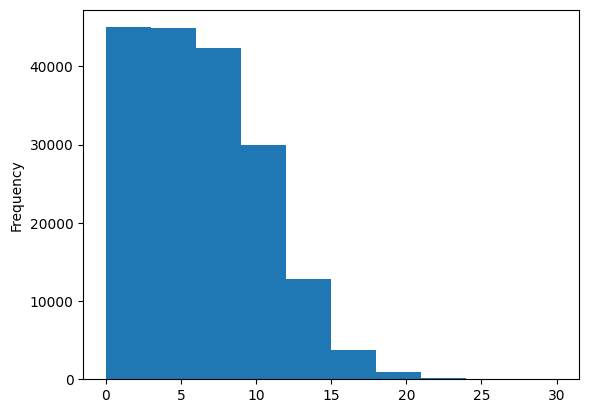

In [ ]:
# Check distribution of `line_number` column
train_df.line_number.plot.hist()

Here we see that majority of lines have a position of 15 or less.
Hence set `depth` parameter of `tf.one_hot` to 15

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our `line_number` column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
# Check one-hot encoded `line_number` feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

We can do the same as we have done for our `line_number` column with the `total_lines` column. First, let's find an appropriate value for the `depth` parameter of `tf.one_hot`.

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

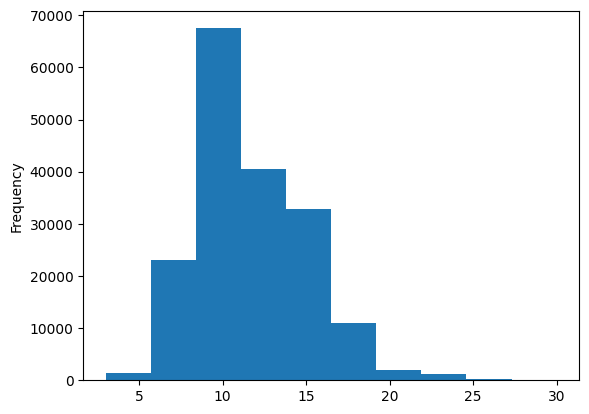

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In this distribution we see a value of 20 covers the majority of samples.

In [ ]:
# Check the coverage of a 'total_lines' value of 20
np.percentile(train_df.total_lines, 95)

18.0

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

A value of 20 covers 98% of samples

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

#### Building a tribrid embedding model

We are building a model which incorporate token embeddings, character embeddings and our newly creafted positional embeddings.

We are going to go through following steps:
1. Create a token-level model
2. Create a character-level model
3. Create a `line_number` model (takes in one-hot-encoded line_number tensor and passes it through a non-linear layer)
4. Create a `total_lines` model (takes in one-hot-encoded total_lines tensor and passes it through a non-linear layer)
5. Combine (using `layers.Concatenate`) the output of 1 and 2 into a token-character-hybrid embedding and pass it through a series of outputs as in research paper.
6. Combine (using `layers.Concatenate`) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of 7 into a `tf.keras.Model`

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total Lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

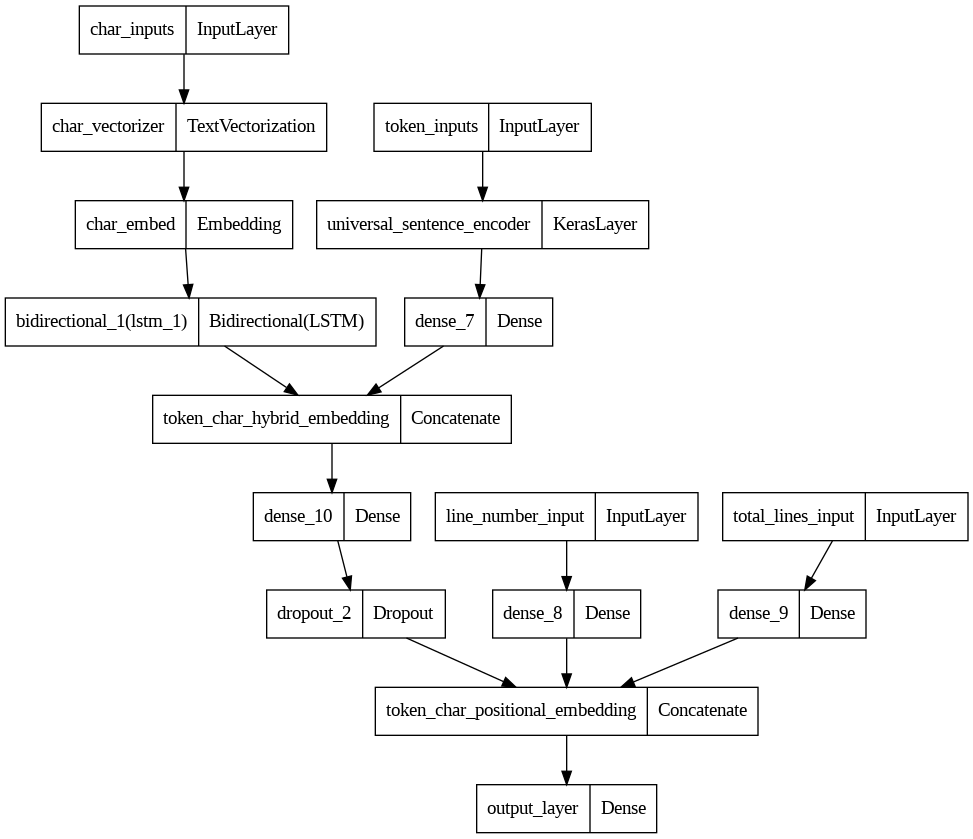

In [ ]:
# Plot the token, char, positional embeddings model
plot_model(model_5)

Our model is looking very similar to the model in research paper. However, a few differences still remain:
- We're using pretrained TF Hub token embeddings instaed of GloVe embeddings.
- We're using a Dense Layer on top of our token-character hybrid embeddings instead of a bi-LSTM layer.
- Paper mentions a label sequence optimization layer (which helps to make sure sequence labels come out in a respectable order). To makeup for the lack of this layer in our model, we've created the positional embeddings layers.
- Paper mentions the token and character embeddings are updated during training, our pretrained TF Hub embeddings remain frozen.
- The paper uses the SGD optimizer, we are going to stick with `Adam`.

In [ ]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b28e2aba110> True
<keras.src.engine.input_layer.InputLayer object at 0x7b28d03be350> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7b27d54775b0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7b28e2a57190> False
<keras.src.layers.core.embedding.Embedding object at 0x7b27d54be140> True
<keras.src.layers.core.dense.Dense object at 0x7b28e2a56590> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7b286c6b23e0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7b2973d99e40> True
<keras.src.engine.input_layer.InputLayer object at 0x7b27d4242c80> True
<keras.src.engine.input_layer.InputLayer object at 0x7b27d43c65c0> True
<keras.src.layers.core.dense.Dense object at 0x7b286c786dd0> True
<keras.src.layers.core.dense.Dense object at 0x7b28e4d5bbb0> True
<keras.src.layers.core.dense.Dense object at 0x7b27d43c6140> True
<keras.src.layers.regularization.dropout.

We're also going to introduce a new paramete to our loss functino called `label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get focused on applying one particular label to a sample.

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Creating tribrid embedding dataset

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token level sequences tensor (`train_sentences`)
4. Char level sequences tensor (`train_chars`)

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fit the tribrid model

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=4,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/4
562/562 [==============================] - 25s 36ms/step - loss: 1.1006 - accuracy: 0.7193 - val_loss: 0.9860 - val_accuracy: 0.8045
Epoch 2/4
562/562 [==============================] - 19s 34ms/step - loss: 0.9702 - accuracy: 0.8118 - val_loss: 0.9506 - val_accuracy: 0.8275
Epoch 3/4
562/562 [==============================] - 19s 34ms/step - loss: 0.9521 - accuracy: 0.8226 - val_loss: 0.9402 - val_accuracy: 0.8328
Epoch 4/4
562/562 [==============================] - 18s 32ms/step - loss: 0.9414 - accuracy: 0.8339 - val_loss: 0.9303 - val_accuracy: 0.8351


In [ ]:
# Make predictions and calculate results
model_5_results = predict_and_result(model_5, valid_dataset=val_pos_char_token_dataset)
model_5_results

945/945 [==============================] - 18s 18ms/step


{'accuracy': 0.8362571163775983,
 'precision': 0.8406934134687808,
 'recall': 0.8362571163775983,
 'f1_score': 0.8317633596788223}

### Model 6: Model 2 -> Replacing TF Hub Universal Sentence Encoder with TF Hub BERT PubMed expert

Bert PubMed Expert is fine-tuned in a self-supervised manner on the MEDLINE/Pubmed corpus.

link: https://www.kaggle.com/models/google/experts-bert/frameworks/tensorFlow2/variations/pubmed/versions/2?tfhub-redirect=true

In [50]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.6 MB/s eta 0:00:00


In [51]:
import tensorflow_text as text
import tensorflow_hub as hub

# Load the BERT encoder and preprocessing models
preprocessing_layer = hub.KerasLayer('https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3', name='pubmed_bert_preprocessor')
bert_layer = hub.KerasLayer('https://www.kaggle.com/models/google/experts-bert/frameworks/TensorFlow2/variations/pubmed/versions/2', name='bert_model_layer')

In [ ]:
# Creating a model out of it
inputs = layers.Input(shape=[], dtype=tf.string, name='input_sentences')
bert_inputs = preprocessing_layer(inputs)
bert_embedding = bert_layer(bert_inputs)
x = layers.Dense(128, activation="relu")(bert_embedding['pooled_output'])
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)

# Packing into a mdoel
model_6 = tf.keras.Model(inputs, outputs)

# Get summary of model
model_6.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_sentences (InputLaye  [(None,)]                    0         []                            
 r)                                                                                               
                                                                                                  
 pubmed_bert_preprocessor (  {'input_type_ids': (None,    0         ['input_sentences[0][0]']     
 KerasLayer)                 128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                    

In [ ]:
# Making datasets for the pubmed model

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Compiling the model
model_6.compile(loss="CategoricalCrossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

# Fit the model
model_6.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=4,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/4
562/562 [==============================] - 276s 462ms/step - loss: 0.6539 - accuracy: 0.7736 - val_loss: 0.4447 - val_accuracy: 0.8428
Epoch 2/4
562/562 [==============================] - 220s 392ms/step - loss: 0.5191 - accuracy: 0.8230 - val_loss: 0.4369 - val_accuracy: 0.8404
Epoch 3/4
562/562 [==============================] - 231s 411ms/step - loss: 0.4979 - accuracy: 0.8260 - val_loss: 0.4285 - val_accuracy: 0.8511
Epoch 4/4
562/562 [==============================] - 238s 423ms/step - loss: 0.4873 - accuracy: 0.8322 - val_loss: 0.4075 - val_accuracy: 0.8554


In [ ]:
model_6_results = predict_and_result(model_6, valid_dataset=valid_dataset)
model_6_results

945/945 [==============================] - 347s 366ms/step


{'accuracy': 0.8569442605587184,
 'precision': 0.8562185556798367,
 'recall': 0.8569442605587184,
 'f1_score': 0.8542625313527742}

### Model 7: Tribrid_model -> Replacing features `line_number` and `total_lines` with `line_number_of_total_lines` and replacing USE with PubMed Bert Expert

In [52]:
# Combining the total lines and line number into a new feature

train_df["line_number_total"] = train_df["line_number"].astype(str) + "_of_" + train_df["total_lines"].astype(str)
val_df["line_number_total"] = val_df["line_number"].astype(str) + "_of_" + val_df["total_lines"].astype(str)
test_df["line_number_total"] = test_df["line_number"].astype(str) + "_of_" + test_df["total_lines"].astype(str)

train_df.head(10)

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11,5_of_11
6,RESULTS,there was a clinically relevant reduction in t...,6,11,6_of_11
7,RESULTS,the mean difference between treatment arms ( @...,7,11,7_of_11
8,RESULTS,"further , there was a clinically relevant redu...",8,11,8_of_11
9,RESULTS,these differences remained significant at @ we...,9,11,9_of_11


In [53]:
# Perform one hot encoding on the train and transform the validation, test dataframe
from sklearn.preprocessing import OneHotEncoder

# Creating an instance
ohe = OneHotEncoder()

# Fitting on the training dataframe
ohe.fit(np.expand_dims(train_df["line_number_total"], axis=1))

# Transforming train, val and test df
train_line_number_total_encoded = ohe.transform(np.expand_dims(train_df["line_number_total"], axis=1))
val_line_number_total_encoded = ohe.transform(np.expand_dims(val_df["line_number_total"], axis=1))
test_line_number_total_encoded = ohe.transform(np.expand_dims(test_df["line_number_total"], axis=1))

# Checking the shapes
train_line_number_total_encoded.shape, val_line_number_total_encoded.shape

((180040, 460), (30212, 460))

In [54]:
# Converting the sparse object to array
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
val_line_number_total_encoded = val_line_number_total_encoded.toarray()
test_line_number_total_encoded = test_line_number_total_encoded.toarray()

# Converting the datatype to tf.int
train_line_number_total_encoded = tf.cast(train_line_number_total_encoded, dtype=tf.int32)
val_line_number_total_encoded = tf.cast(val_line_number_total_encoded, dtype=tf.int32)
test_line_number_total_encoded = tf.cast(test_line_number_total_encoded, dtype=tf.int32)

In [55]:
# Making the performant datasets for our tribrid model
train_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                 train_chars,
                                                 train_line_number_total_encoded))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

val_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                               val_chars,
                                               val_line_number_total_encoded))

val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

# Zipping the data and labels
train_dataset = tf.data.Dataset.zip((train_data, train_labels))
val_dataset = tf.data.Dataset.zip((val_data, val_labels))

# Applying batch and prefetching
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Now lets build a tribrid model which uses PubMed Bert as the embedding and model plus our new feature `line_number_total`.

In [56]:
# Building the tribrid model using the functional api

input_token = layers.Input(shape=[], dtype=tf.string)
bert_input_token = preprocessing_layer(input_token)
bert_embedding_token = bert_layer(bert_input_token)
output_token = layers.Dense(64, activation="relu")(bert_embedding_token["pooled_output"])
token_model = tf.keras.Model(input_token, output_token)

input_char = layers.Input(shape=[], dtype=tf.string)
bert_inputs_char = preprocessing_layer(input_char)
bert_embedding_char = bert_layer(bert_inputs_char)
output_char = layers.Dense(64, activation="relu")(bert_embedding_char["pooled_output"])
char_model = tf.keras.Model(input_char, output_char)

line_number_total_input = layers.Input(shape=(460,), dtype=tf.int32)
x = layers.Dense(32, activation="relu")(line_number_total_input)
total_line_number_model = tf.keras.Model(line_number_total_input, x)

# Concatenating the tokens and chars output (hybrid)
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

# Combining the line_number_total to our hybrid model (tribrid!)
z = layers.Concatenate(name="tribrid_embeddings")([total_line_number_model.output,
                                                   combined_embeddings])

# Adding a  dense + dropout and creating our output layer
dropout = layers.Dropout(0.5)(z)
x = layers.Dense(128, activation="relu")(dropout)
output_layer = layers.Dense(5, activation="softmax")(x)

# Packing into a model
model_7 = tf.keras.Model(inputs=[token_model.input,
                                   char_model.input,
                                   total_line_number_model.input],
                         outputs=output_layer)

# Get summary of model 7
model_7.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 pubmed_bert_preprocessor (  {'input_word_ids': (None,    0         ['input_2[0][0]',             
 KerasLayer)                 128),                                   'input_3[0][0]']             
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                     

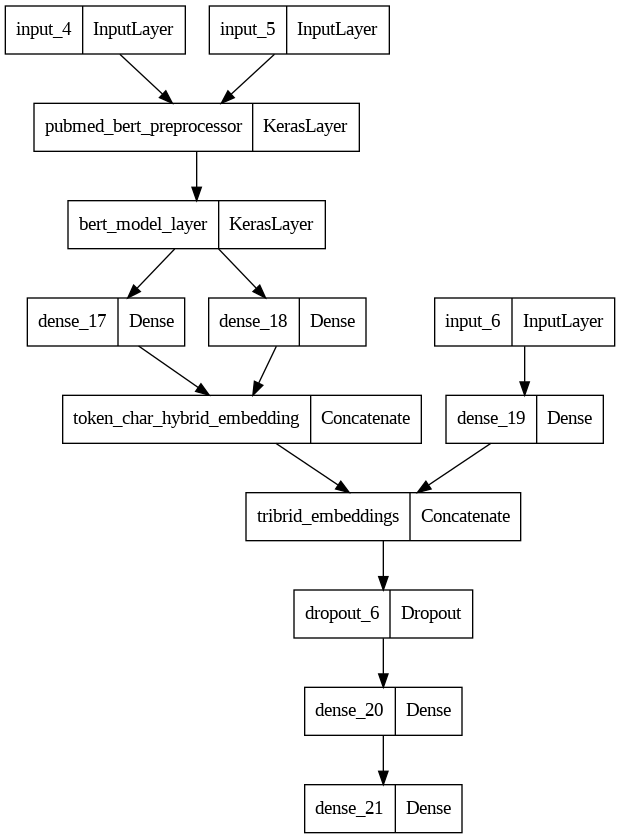

In [ ]:
# Plot the model structure
plot_model(model_7)

In [57]:
# Compiling and fitting the model on 10% of the data
model_7.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=4,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/4
562/562 [==============================] - 510s 882ms/step - loss: 0.6595 - accuracy: 0.7653 - val_loss: 0.3841 - val_accuracy: 0.8634
Epoch 2/4
562/562 [==============================] - 488s 869ms/step - loss: 0.4370 - accuracy: 0.8463 - val_loss: 0.3327 - val_accuracy: 0.8703
Epoch 3/4
562/562 [==============================] - 454s 807ms/step - loss: 0.4029 - accuracy: 0.8555 - val_loss: 0.3253 - val_accuracy: 0.8830
Epoch 4/4
562/562 [==============================] - 471s 839ms/step - loss: 0.3844 - accuracy: 0.8607 - val_loss: 0.3114 - val_accuracy: 0.8866


In [ ]:
# Check results on whole validation dataset
model_7_results = predict_and_result(model_7, valid_dataset=val_dataset)
model_7_results

945/945 [==============================] - 660s 699ms/step


{'accuracy': 0.8904739838474778,
 'precision': 0.8921888108299092,
 'recall': 0.8904739838474778,
 'f1_score': 0.8883860820468749}

## Compare results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results,
                                  "PubMed BERT Expert": model_6_results,
                                  "tribrid_PubMed_BERT": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1_score
baseline,0.721832,0.718647,0.721832,0.698925
custom_token_embed_conv1d,0.793890,0.794935,0.793890,0.789052
pretrained_token_embed,0.728916,0.723997,0.728916,0.723263
custom_char_embed_conv1d,0.664107,0.667720,0.664107,0.654740
hybrid_char_token_embed,0.744671,0.742621,0.744671,0.739928
tribrid_pos_char_token_embed,0.836257,0.840693,0.836257,0.831763
PubMed BERT Expert,0.856944,0.856219,0.856944,0.854263
tribrid_PubMed_BERT,0.890474,0.892189,0.890474,0.888386


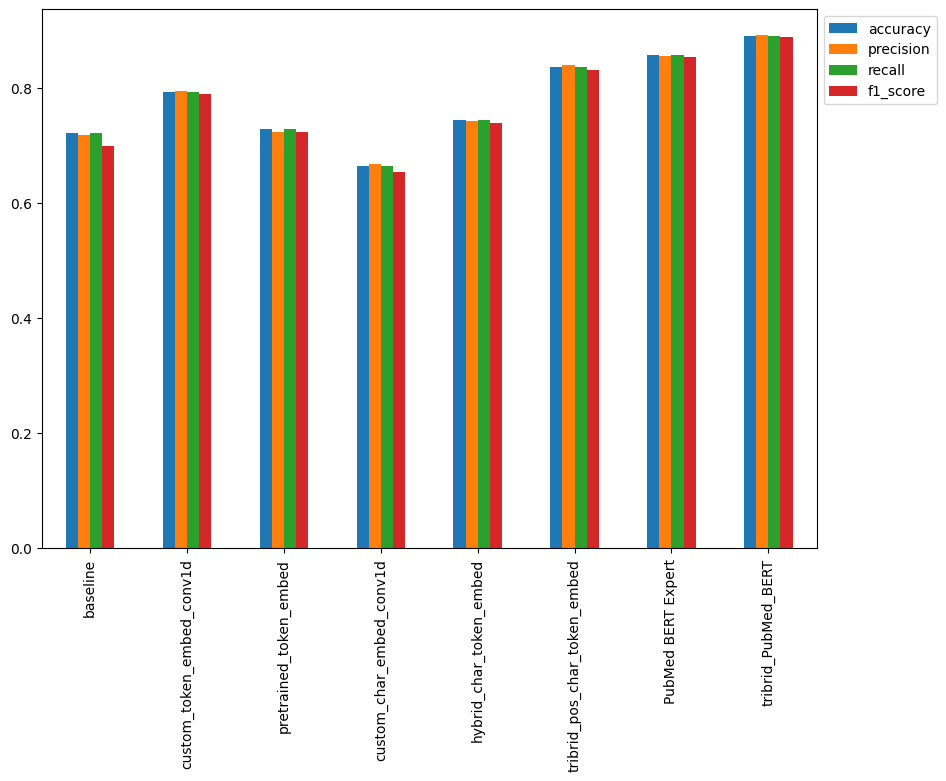

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

🔑 Finally we can conclude that our model_7: Tribrid model with PubMed_BERT_Expert is the best model so far.

## Training the best model on all of the data in the training dataset until the model stops improving.

In [ ]:
# Creating the callbacks
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_filepath,
                                                               save_weights_only=True,
                                                               save_best_only=True,
                                                               save_freq="epoch",
                                                               monitor="val_loss")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  min_delta=0.5,
                                                  verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
# Creating best model

input_token = layers.Input(shape=[], dtype=tf.string)
bert_input_token = preprocessing_layer(input_token)
bert_embedding_token = bert_layer(bert_input_token)
output_token = layers.Dense(64, activation="relu")(bert_embedding_token["pooled_output"])
token_model = tf.keras.Model(input_token, output_token)

input_char = layers.Input(shape=[], dtype=tf.string)
bert_inputs_char = preprocessing_layer(input_char)
bert_embedding_char = bert_layer(bert_inputs_char)
output_char = layers.Dense(64, activation="relu")(bert_embedding_char["pooled_output"])
char_model = tf.keras.Model(input_char, output_char)

line_number_total_input = layers.Input(shape=(460,), dtype=tf.int32)
x = layers.Dense(32, activation="relu")(line_number_total_input)
total_line_number_model = tf.keras.Model(line_number_total_input, x)

# Concatenating the tokens and chars output (hybrid)
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

# Combining the line_number_total to our hybrid model (tribrid!)
z = layers.Concatenate(name="tribrid_embeddings")([total_line_number_model.output,
                                                   combined_embeddings])

# Adding a  dense + dropout and creating our output layer
dropout = layers.Dropout(0.5)(z)
x = layers.Dense(128, activation="relu")(dropout)
output_layer = layers.Dense(5, activation="softmax")(x)

# Packing into a model
best_model = tf.keras.Model(inputs=[token_model.input,
                                   char_model.input,
                                   total_line_number_model.input],
                            outputs=output_layer)

In [ ]:
# Compiling the best model and fitting it on the 100% of the data for 50 epochs!
best_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

best_model.fit(train_dataset,
              epochs=50,
              validation_data=val_dataset,
              callbacks=[early_stopping, model_checkpoint_callback, reduce_lr])

Epoch 1/50
2541/5627 [============>.................] - ETA: 36:06 - loss: 0.9438 - accuracy: 0.8351

KeyboardInterrupt: 

## Save the best model

In [65]:
!mkdir -p saved_model
model_7.save('saved_model/my_model')

## Create function which accepts an abstract and return classified sentences

In [66]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [79]:
from spacy.lang.en import English

nlp = English()
sentencizer = nlp.add_pipe("sentencizer")

def split_chars(text):
    return " ".join(list(text))

def transform_abstract(abstract):
    doc = nlp(abstract)
    abstract_lines = [str(sent) for sent in list(doc.sents)]
    abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
    # Get total number of lines
    total_lines_in_sample = len(abstract_lines)

    # Go through each line in abstract and create a list of dictionaries containing features
    sample_lines = []
    for i, line in enumerate(abstract_lines):
        sample_dict = {}
        sample_dict["text"] = str(line)
        sample_dict["line_number"] = i
        sample_dict["total_lines"] = total_lines_in_sample - 1
        sample_lines.append(sample_dict)

    df = pd.DataFrame(sample_lines)
    df["line_number_total"] = df["line_number"].astype(str) + "_of_" + df["total_lines"].astype(str)
    line_number_total_encoded = ohe.transform(np.expand_dims(df["line_number_total"], axis=1))
    line_number_total_encoded = tf.cast(line_number_total_encoded.toarray(), dtype=tf.int32)
    return (abstract_lines, abstract_chars, line_number_total_encoded, df)

def classify_sentences(abstract, label_encoder, model=new_model):
    a, b, c, df = transform_abstract(abstract)
    prediction = model.predict(x=(tf.constant(a), tf.constant(b), c))

    # Turn prediction probs to pred class
    abstract_preds = tf.argmax(prediction, axis=1)

      # Prediction class integers into string class name
    abstract_pred_classes = [label_encoder.classes_[i] for i in abstract_preds]

  # Prints out the abstract lines and the predicted sequence labels
    for i , line in enumerate(a):
      print(f'{abstract_pred_classes[i]}:  {line}\n')

In [73]:
abstract = "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group."
print(abstract)

This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


In [80]:
classify_sentences(abstract, label_encoder)

1/1 [==============================] - 0s 101ms/step
BACKGROUND:  This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

METHODS:  Participants were randomly assigned to treatment or wait-list conditions.

METHODS:  Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

METHODS:  A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

RESULTS:  Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

RESULTS:  Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

RESULTS:  High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

CONCLUSIONS:  Standardized effect size estimates were primarily in the medium and larg